## Summary

1. [Setup](#1.-Setup)
1. [Data Loading](#2.-Data-Loading)
1. [Networks Definition](#3.-Networks-Definition)
1. [Edge Weights: Distributions and Correlations](#4.-Edge-Weights:-Distributions-and-Correlations)
1. [Centrality Indexes: Distributions and Correlations](#5.-Centrality-Indexes:-Distributions-and-Correlations)

## 1. Setup

### 1.1. Modules

In [75]:
import os.path
import pandas as pd
import urllib

import numpy as np
import scipy.stats as st

import networkx as nx
import networkx.algorithms.bipartite.projection as projection
import networkx.algorithms.shortest_paths.dense as dense
from sklearn.metrics import accuracy_score
import cycler
from sklearn.semi_supervised import LabelPropagation
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({
    'font.size': 16,
    'font.family': 'serif',
    'figure.figsize': (13, 8),
    'axes.prop_cycle': cycler.cycler(
        marker=['s', 'v', 'o', '*']*2,
        markersize=[8]*8,
        linestyle=['-']*8,
        color=sns.color_palette("Set1", 8))
})

from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}</style>"))

#import utility

smoothing_eps = 1

### 1.2. Data

In [76]:
ls

 O volume na unidade C não tem nome.
 O Número de Série do Volume é BA3B-F5D9

 Pasta de C:\Users\willi\Documents\Privisao de votacao

30/04/2022  00:58    <DIR>          .
30/04/2022  00:58    <DIR>          ..
16/04/2022  18:22    <DIR>          .ipynb_checkpoints
30/04/2022  00:58           182.830 Aprendizado semi-supervisionado para predição de votações.ipynb
17/04/2022  22:44               188 colog_dan_experiment
23/04/2022  10:12        73.596.231 colog_dan_experiment_2
27/04/2022  02:47        91.894.417 colog_dan_experiment_completo_final
16/04/2022  18:16    <DIR>          Dados da camara
29/04/2022  18:02           795.527 matriz_Votacao
29/04/2022  18:02           795.527 matriz_Votacao.csv
16/04/2022  18:18        12.939.565 Predição_de_votações.ipynb
               7 arquivo(s)    180.204.285 bytes
               4 pasta(s)   463.412.686.848 bytes disponíveis


In [77]:
year_train = 2019 # Fazer com 2019 que é o que tem mais votações
year_test = 2018
datafile_dir = './Dados da camara'
datafile_separator = ';'
datafile_name_template = 'votacoesVotos-{}.csv'
datafile_url_template = 'http://dadosabertos.camara.leg.br/arquivos/votacoesVotos/csv/votacoesVotos-{}.csv'

## 2. Data Loading

In [78]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [79]:
# All data
interval = (2018, 2019)
data_merged = pd.DataFrame()

datafile_dir = os.path.expanduser(datafile_dir)

for year in range(interval[0], interval[1] + 1):
    datafile_name = datafile_name_template.format(year)
    datafile_path = os.path.join(datafile_dir, datafile_name)
    
    if not os.path.exists(datafile_path):
        urllib.request.urlretrieve(datafile_url_template.format(year), datafile_path)
        
    data_merged = pd.concat([data_merged, pd.read_csv(datafile_path, sep=datafile_separator)])

In [80]:
data = pd.DataFrame()
data_test = pd.DataFrame()

datafile_dir = os.path.expanduser(datafile_dir)

#for year in range(interval[0], interval[1] + 1):
datafile_name = datafile_name_template.format(year_train)
datafile_path = os.path.join(datafile_dir, datafile_name)

if not os.path.exists(datafile_path):
    urllib.request.urlretrieve(datafile_url_template.format(year_train), datafile_path)

data = pd.concat([data, pd.read_csv(datafile_path, sep=datafile_separator)])

# Data for test : 2018
datafile_name = datafile_name_template.format(year_test)
datafile_path = os.path.join(datafile_dir, datafile_name)

if not os.path.exists(datafile_path):
    urllib.request.urlretrieve(datafile_url_template.format(year_test), datafile_path)

data_test = pd.concat([data_test, pd.read_csv(datafile_path, sep=datafile_separator)])

In [81]:
data_merged = data_merged.dropna()

data_merged.dataHoraVoto = pd.to_datetime(data.dataHoraVoto)

data_merged.voto = data_merged.voto.replace({
    'Não': 0,
    'Sim': 1,
    'Obstrução': 2,
    'Abstenção': 2
})


data = data.dropna()

data.dataHoraVoto = pd.to_datetime(data.dataHoraVoto)

data.voto = data.voto.replace({
    'Não': 0,
    'Sim': 1,
    'Obstrução': 2,
    'Abstenção': 2
})

data_test = data_test.dropna()
data_test.dataHoraVoto = pd.to_datetime(data_test.dataHoraVoto)
data_test.voto = data_test.voto.replace({
    'Não': 0,
    'Sim': 1,
    'Obstrução': 2,
    'Abstenção': 2
})

In [82]:
pd.DataFrame({'tipo': data.dtypes, 'valores unicos': data.nunique()})

,tipo,valores unicos
idVotacao,object,333
uriVotacao,object,333
dataHoraVoto,datetime64[ns],67470
voto,object,4
deputado_id,int64,531
deputado_uri,object,531
deputado_nome,object,531
deputado_siglaPartido,object,35
deputado_uriPartido,object,35
deputado_siglaUf,object,27


In [83]:
pd.DataFrame({'tipo': data_test.dtypes, 'valores unicos': data_test.nunique()})

,tipo,valores unicos
idVotacao,object,141
uriVotacao,object,141
dataHoraVoto,datetime64[ns],31348
voto,object,4
deputado_id,int64,552
deputado_uri,object,552
deputado_nome,object,553
deputado_siglaPartido,object,29
deputado_uriPartido,object,31
deputado_siglaUf,object,27


## 3. Networks Definition

In [84]:
bipartite_network = nx.from_pandas_edgelist(data, 'deputado_id', 'idVotacao', 'voto')

In [85]:
def smoothed_ratio(a, b, eps=smoothing_eps):
    return (a + eps) / (b + 2*eps)

In [86]:
def congress_proximity(G, u, v):
    a = set(G[u])
    b = set(G[v])
    aub = a.union(b)
    aeb = a.intersection(b)
    
    num_covotes = sum(G[u][i]['voto'] == G[v][i]['voto'] for i in aeb)
    
    return smoothed_ratio(num_covotes, len(aeb))     # cv:   co-voting

In [87]:
bp_projection = projection.generic_weighted_projected_graph(bipartite_network, data.deputado_id.unique(), congress_proximity)

In [88]:
len(bp_projection.edges)/(len(bp_projection) * (len(bp_projection) - 1)/2)

0.9974132111004512

In [89]:
dan = nx.Graph()
edges = [(e[0], e[1], {'cv': e[2]['weight']})
         for e in bp_projection.edges(data=True)]
dan.add_edges_from(edges)

In [90]:
def project_edge_weights(graph, projection):
    projected = nx.Graph()
    edges = [(e[0], e[1], {k: projection(e[2][k]) for k in e[2]}) for e in graph.edges(data=True)]
    projected.add_edges_from(edges)
    return projected

In [91]:
colog_dan = project_edge_weights(dan, lambda w: -np.log(w))
ddn = project_edge_weights(dan, lambda w: 1-w)
colog_ddn = project_edge_weights(ddn, lambda w: -np.log(w))

**LabelPropagation:** The function passed should take two inputs, each of shape (n_samples, n_features), and return a (n_samples, n_samples) shaped weight matrix.         An array where each row is a sample and each column is a feature.


In [92]:
def callback_adj_matrix(n_samples, n_features=None):
    return n_samples

In [93]:
# percentual de votos conhecidos
pvc = [ 0.2, 0.5, 0.8 ]

In [94]:
# 2. Para cada votação [id_votação]

In [104]:
def get_targets(idVotacao,dataset,graph=dan):
    y = []
    total = 0
    twos = 0
    #idVotacao = '2086181-35'
    for deputado_id in list(dan.nodes()):
        if deputado_id in dataset[dataset['idVotacao'] == idVotacao]['deputado_id'].tolist():
            voto = dataset[(dataset['idVotacao'] == idVotacao) & (dataset['deputado_id'] == deputado_id)]['voto']
            if (voto.values[0] == 0 or voto.values[0] == 1):
                y.append(voto.values[0])
            else:
                twos += 1
                y.append(2) # 2 é 'outros', abstenção, obstrução, faltas, e quaisquer outras coisas além de 'sim' ou 'não'    
        else:
            twos += 1
            y.append(2) # 2 é 'outros', abstenção, obstrução, faltas, e quaisquer outras coisas além de 'sim' ou 'não'
    two_percetage = twos/len(y)
    return y, two_percetage

In [96]:
colog_dan_adj_matrix = nx.adjacency_matrix(colog_dan,weight='cv').toarray()
ddn_adj_matrix = nx.adjacency_matrix(ddn,weight='cv').toarray()
dan_adj_matrix = nx.adjacency_matrix(dan,weight='cv').toarray()
colog_ddn_adj_matrix = -nx.adjacency_matrix(colog_ddn,weight='cv').toarray()

In [97]:
edges = [(u, v, {'cv': colog_dan_adj_matrix[i][j]}) 
         for i, u in enumerate(colog_dan) for j, v in enumerate(colog_dan) if i < j]

colog_can = nx.Graph()
colog_can.add_edges_from(edges)
colog_can_adj_matrix = nx.adjacency_matrix(colog_can,weight='cv').toarray()

In [98]:
adj_matrices = [(colog_dan_adj_matrix,colog_dan,'colog_dan'),(ddn_adj_matrix,ddn,'ddn'),(dan_adj_matrix,dan,'dan'),(colog_ddn_adj_matrix,colog_ddn,'colog_ddn'),(colog_can_adj_matrix,colog_can,'colog_can')]

Registra a tupla [id_votação, pvc, repetição, tipo_rede,acurácia]

In [ ]:
id_votacao = '16526-506'
percentage = 0.2
y = get_targets(id_votacao,data,dan) # calclula o y
rng = np.random.RandomState(1)
random_unlabeled_points = rng.rand(len(y)) < percentage
labels = np.copy(y)
labels[random_unlabeled_points] = -1
label_prop_model = LabelPropagation(kernel=callback_adj_matrix,tol= 0.0000001)
label_propagatio_trained = label_prop_model.fit(adj_matrices[3][0].copy(),labels)
print("Label: ", labels)
print("Classes: ", label_prop_model.classes_)
print("Label Distributions: ", label_prop_model.label_distributions_)
print("Transduction Label: ", label_prop_model.transduction_)
print("Predict:", label_prop_model.predict(adj_matrices[3][0]))
print("No. of features: ", label_prop_model.n_features_in_)
print("No. of iterations: ", label_prop_model.n_iter_)
print("Accuracy:",accuracy_score(y, label_prop_model.predict(adj_matrices[3][0])))
#print(ca_dist_mtx)
# 0.0.3314500941619586 adj_matrices[1][0]
# 0.6346516007532956 adj_matrices[2][0]
# 0.6610169491525424 adj_matrices[3][0]

In [112]:
# classo 2 distribution
two_distribution = []
for id_votacao in data_test['idVotacao'].unique(): # Para cada votação do conjunto de teste (2018)
    y, two_percentage = get_targets(id_votacao,data_test,dan) # calclula o y
    two_distribution.append(two_percentage)

In [111]:
# classo 2 distribution
two_distribution_data = []
for id_votacao in data['idVotacao'].unique(): # Para cada votação do conjunto de teste (2018)
    y, two_percentage = get_targets(id_votacao,data,dan) # calclula o y
    two_distribution_data.append(two_percentage)

In [113]:
min(two_distribution)

0.6120527306967984

In [114]:
min(two_distribution_data)

0.03954802259887006

In [ ]:
pvc = [ 0.2, 0.5, 0.8 ]
results = []
repeticoes = 10
label_prop_model = LabelPropagation(kernel=callback_adj_matrix)
for percentage in pvc:
    count = 0
    for id_votacao in data_test['idVotacao'].unique(): # Para cada votação do conjunto de teste (2018)
        y, two_percentage = get_targets(id_votacao,data_test,dan) # calclula o y
        if two_percentage < 0.3:
            print('two_percentage', two_percentage)
        for repeticao in range(repeticoes):
            rng = np.random.RandomState(repeticao)
            random_unlabeled_points = rng.rand(len(y)) < percentage
            labels = np.copy(y)
            labels[random_unlabeled_points] = -1
            for adj_matrix in adj_matrices:    
                label_prop_model.fit(adj_matrix[0].copy(),labels)
                print(adj_matrix[2])
                #print('pred', y_pred)
                y_pred = label_prop_model.predict(adj_matrix[0].copy())
                result = (id_votacao,percentage,repeticao,adj_matrix[2],accuracy_score(y, y_pred), y_pred,y,labels)
                print(accuracy_score(y, y_pred))
                results.append(result)
                count+=1
    print(result)
    print("count:", count)

In [65]:
df_results = pd.DataFrame(results, columns =['idVotacao', 'pvc', 'repeticao','rede','acurácia','y_pred','y','labels'])


In [66]:
df_results['acurácia']

0        0.949153
1        0.949153
2        0.949153
3        0.949153
4        0.949153
           ...   
21145    0.725047
21146    0.725047
21147    0.725047
21148    0.725047
21149    0.725047
Name: acurácia, Length: 21150, dtype: float64

In [67]:
df_results.to_csv('colog_dan_experiment_completo_final')

In [118]:
df_results = pd.read_csv('colog_dan_experiment_completo_final')

In [119]:
df_results.head()

,Unnamed: 0,idVotacao,pvc,repeticao,rede,acurácia,y_pred,y,labels
0,0,109150-238,0.2,0,colog_dan,0.949153,[2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2...,"[2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, ...",[ 2 2 2 0 2 2 2 2 2 2 2 2 2 2 -1 ...
1,1,109150-238,0.2,0,ddn,0.949153,[2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2...,"[2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, ...",[ 2 2 2 0 2 2 2 2 2 2 2 2 2 2 -1 ...
2,2,109150-238,0.2,0,dan,0.949153,[2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2...,"[2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, ...",[ 2 2 2 0 2 2 2 2 2 2 2 2 2 2 -1 ...
3,3,109150-238,0.2,0,colog_ddn,0.949153,[2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2...,"[2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, ...",[ 2 2 2 0 2 2 2 2 2 2 2 2 2 2 -1 ...
4,4,109150-238,0.2,0,colog_can,0.949153,[2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2...,"[2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, ...",[ 2 2 2 0 2 2 2 2 2 2 2 2 2 2 -1 ...


In [120]:
df_results[(df_results['pvc'] == 0.5) & (df_results['rede'] == adj_matrix[2])]['acurácia'].mean()

0.881995699269411

In [121]:
from collections import defaultdict
d = defaultdict(list)
medias = []
for adj_matrix in adj_matrices:    
    for percentage in pvc:
        media = df_results[(df_results['pvc'] == percentage) & (df_results['rede'] == adj_matrix[2])]['acurácia'].mean()
        #dict_result[percentage] = (adj_matrix[2],medias)
        d[adj_matrix[2]].append((percentage, media))

In [122]:
d['colog_dan']

[(0.2, 0.9516341440611188),
 (0.5, 0.881995699269411),
 (0.8, 0.8088632447810237)]

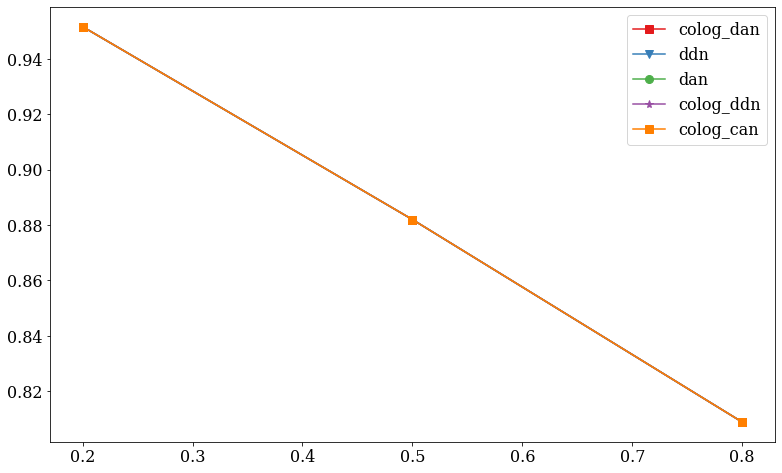

In [124]:
from matplotlib import pyplot as plt

# Median Developer Salaries by Age
for adj_matrix in adj_matrices:    
    plt.plot(*zip(*d[adj_matrix[2]]),label = adj_matrix[2])
plt.legend()
plt.show()

# Método sem grafo

In [162]:
data.head()

,idVotacao,uriVotacao,dataHoraVoto,voto,deputado_id,deputado_uri,deputado_nome,deputado_siglaPartido,deputado_uriPartido,deputado_siglaUf,deputado_idLegislatura,deputado_urlFoto
0,16526-506,https://dadosabertos.camara.leg.br/api/v2/vota...,2019-06-17T19:27:01,Não,204554,https://dadosabertos.camara.leg.br/api/v2/depu...,Abílio Santana,PL,https://dadosabertos.camara.leg.br/api/v2/part...,BA,56,http://www.camara.gov.br/internet/deputado/ban...
1,16526-506,https://dadosabertos.camara.leg.br/api/v2/vota...,2019-06-17T19:27:27,Não,204521,https://dadosabertos.camara.leg.br/api/v2/depu...,Abou Anni,PSL,https://dadosabertos.camara.leg.br/api/v2/part...,SP,56,http://www.camara.gov.br/internet/deputado/ban...
2,16526-506,https://dadosabertos.camara.leg.br/api/v2/vota...,2019-06-17T19:29:44,Não,204560,https://dadosabertos.camara.leg.br/api/v2/depu...,Adolfo Viana,PSDB,https://dadosabertos.camara.leg.br/api/v2/part...,BA,56,http://www.camara.gov.br/internet/deputado/ban...
3,16526-506,https://dadosabertos.camara.leg.br/api/v2/vota...,2019-06-17T19:26:40,Não,204528,https://dadosabertos.camara.leg.br/api/v2/depu...,Adriana Ventura,NOVO,https://dadosabertos.camara.leg.br/api/v2/part...,SP,56,http://www.camara.gov.br/internet/deputado/ban...
4,16526-506,https://dadosabertos.camara.leg.br/api/v2/vota...,2019-06-17T19:27:21,Não,121948,https://dadosabertos.camara.leg.br/api/v2/depu...,Adriano do Baldy,PP,https://dadosabertos.camara.leg.br/api/v2/part...,GO,56,http://www.camara.gov.br/internet/deputado/ban...


In [27]:
matriz_votacao = []
count = 0
for deputado_id in data_merged['deputado_id'].unique(): # Para cada votação do conjunto de teste (2018)
    votos_do_deputado = []
    for idVotacao in data_merged['idVotacao'].unique():
        voto = data_merged[(data_merged['idVotacao'] == idVotacao) & (data_merged['deputado_id'] == deputado_id)]['voto']
        if len(voto) != 0:
            if (voto.values[0] == 0 or voto.values[0] == 1):
                votos_do_deputado.append(voto.values[0])
            else:
                votos_do_deputado.append(2) # 2 é 'outros', abstenção, obstrução, faltas, e quaisquer outras coisas além de 'sim' ou 'não'    
        else:
            votos_do_deputado.append(2) # 2 é 'outros', abstenção, obstrução, faltas, e quaisquer outras coisas além de 'sim' ou 'não'    
    print('count = ',count)
    count += 1
    
    matriz_votacao.append(votos_do_deputado)
    

count =  0
count =  1
count =  2
count =  3
count =  4
count =  5
count =  6
count =  7
count =  8
count =  9
count =  10
count =  11
count =  12
count =  13
count =  14
count =  15
count =  16
count =  17
count =  18
count =  19
count =  20
count =  21
count =  22
count =  23
count =  24
count =  25
count =  26
count =  27
count =  28
count =  29
count =  30
count =  31
count =  32
count =  33
count =  34
count =  35
count =  36
count =  37
count =  38
count =  39
count =  40
count =  41
count =  42
count =  43
count =  44
count =  45
count =  46
count =  47
count =  48
count =  49
count =  50
count =  51
count =  52
count =  53
count =  54
count =  55
count =  56
count =  57
count =  58
count =  59
count =  60
count =  61
count =  62
count =  63
count =  64
count =  65
count =  66
count =  67
count =  68
count =  69
count =  70
count =  71
count =  72
count =  73
count =  74
count =  75
count =  76
count =  77
count =  78
count =  79
count =  80
count =  81
count =  82
count =  83
co

count =  639
count =  640
count =  641
count =  642
count =  643
count =  644
count =  645
count =  646
count =  647
count =  648
count =  649
count =  650
count =  651
count =  652
count =  653
count =  654
count =  655
count =  656
count =  657
count =  658
count =  659
count =  660
count =  661
count =  662
count =  663
count =  664
count =  665
count =  666
count =  667
count =  668
count =  669
count =  670
count =  671
count =  672
count =  673
count =  674
count =  675
count =  676
count =  677
count =  678
count =  679
count =  680
count =  681
count =  682
count =  683
count =  684
count =  685
count =  686
count =  687
count =  688
count =  689
count =  690
count =  691
count =  692
count =  693
count =  694
count =  695
count =  696
count =  697
count =  698
count =  699
count =  700
count =  701
count =  702
count =  703
count =  704
count =  705
count =  706
count =  707
count =  708
count =  709
count =  710
count =  711
count =  712
count =  713
count =  714
count =  715

In [28]:
df_matriz_votacao = pd.DataFrame(matriz_votacao)


In [31]:
df_matriz_votacao.to_csv('matriz_Votacao.csv')

In [32]:
df_matriz_votacao.head()

,0,1,2,3,4,5,6,7,8,9,...,464,465,466,467,468,469,470,471,472,473
0,0,1,2,0,1,2,2,2,1,2,...,2,2,2,2,2,2,2,2,2,2
1,0,0,0,0,1,2,1,1,1,2,...,2,2,2,2,2,2,2,2,2,2
2,0,2,2,0,1,2,1,1,2,2,...,2,2,2,2,2,2,2,2,2,2
3,2,1,0,2,1,2,0,1,1,2,...,2,2,2,2,2,2,2,2,2,2
4,0,1,0,2,1,2,1,2,1,2,...,2,2,2,2,2,2,2,2,2,2


In [62]:
df_matriz_votacao.T

,0,1,2,3,4,5,6,7,8,9,...,823,824,825,826,827,828,829,830,831,832
0,0,0,0,2,0,0,0,2,0,0,...,2,2,2,2,2,2,2,2,2,2
1,1,0,2,1,1,2,1,1,1,1,...,2,2,2,2,2,2,2,2,2,2
2,2,0,2,0,0,2,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2
3,0,0,0,2,2,0,0,2,0,0,...,2,2,2,2,2,2,2,2,2,2
4,1,1,1,1,1,2,1,1,1,1,...,2,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469,2,2,2,2,2,2,2,1,1,1,...,1,1,2,2,2,2,2,2,2,2
470,2,2,2,2,2,2,2,0,0,0,...,0,2,2,2,2,2,2,2,2,2
471,2,2,2,2,2,2,2,0,0,0,...,0,0,2,2,2,2,2,2,2,2
472,2,2,2,2,2,2,2,1,1,1,...,1,1,2,2,2,2,2,2,2,2


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_matriz_votacao, df_matriz_votacao, test_size=0.2, random_state=12)

In [37]:
def get_targets_classfification(idVotacao):
    y = []
    #idVotacao = '2086181-35'
    for deputado_id in data_merged['deputado_id'].unique(): # Para cada votação do conjunto de teste (2018)
        if deputado_id in data_merged[data_merged['idVotacao'] == idVotacao]['deputado_id'].tolist():
            voto = data_merged[(data_merged['idVotacao'] == idVotacao) & (data_merged['deputado_id'] == deputado_id)]['voto']
            if (voto.values[0] == 0 or voto.values[0] == 1):
                y.append(voto.values[0])
            else:
                y.append(2) # 2 é 'outros', abstenção, obstrução, faltas, e quaisquer outras coisas além de 'sim' ou 'não'    
        else:
            y.append(2) # 2 é 'outros', abstenção, obstrução, faltas, e quaisquer outras coisas além de 'sim' ou 'não'
    return y

In [125]:
from sklearn.ensemble import RandomForestClassifier

for id_votacao in data_test['idVotacao'].unique(): # Para cada votação do conjunto de teste (2018)
        y = get_targets_classfification(id_votacao) # calclula o y
        rng = np.random.RandomState(repeticao)
        random_forest = RandomForestClassifier(max_depth=8, random_state=0)
        random_forest.fit(df_matriz_votacao, y)
        y_pred = random_forest.predict(df_matriz_votacao)    
        result = (id_votacao,accuracy_score(y, y_pred), y_pred,y,labels)
        print(accuracy_score(y, y_pred))
        results.append(result)
        count+=1
        print('count:', count)


0.9903961584633854
count: 1801
0.9963985594237695
count: 1802
0.9963985594237695
count: 1803
0.9963985594237695
count: 1804
0.9771908763505402
count: 1805
0.9963985594237695
count: 1806
0.992797118847539
count: 1807
0.9843937575030012
count: 1808
0.9819927971188476
count: 1809
1.0
count: 1810
0.9819927971188476
count: 1811
0.9915966386554622
count: 1812
0.9867947178871549
count: 1813
0.978391356542617
count: 1814
0.9915966386554622
count: 1815
0.9915966386554622
count: 1816
0.9939975990396158
count: 1817
0.9975990396158463
count: 1818
1.0
count: 1819
0.9987995198079231
count: 1820
0.9963985594237695
count: 1821
1.0
count: 1822
0.9963985594237695
count: 1823
0.9975990396158463
count: 1824
0.9963985594237695
count: 1825
0.9975990396158463
count: 1826
1.0
count: 1827
0.9975990396158463
count: 1828
0.9975990396158463
count: 1829
1.0
count: 1830
0.9963985594237695
count: 1831
0.9963985594237695
count: 1832
1.0
count: 1833
1.0
count: 1834
0.9975990396158463
count: 1835
0.9987995198079231
cou